In [478]:
# To generate predictions, set real_testing to True and ensure Test_Set_EEG.csv
# is in the working directory. rf_results.csv, svm_results.csv, and xgb_results.csv
# will be generated. Choose xgb_results.csv for judging.

import pandas as pd

df = pd.read_csv('Train_and_Validate_EEG.csv')
test_df = pd.read_csv('Test_Set_EEG.csv')

real_testing = True

In [479]:
# Remove unnecessary columns
from sklearn.impute import SimpleImputer

df = df.iloc[:, :123]
test_df = test_df.iloc[:, :120]

df.drop(columns=['specific.disorder', 'ID', 'eeg.date'], inplace=True)
test_df_ids = test_df[['ID']]
test_df.drop(columns=['eeg.date', 'ID'], inplace=True)

test_df['IQ'].fillna(test_df['IQ'].mean(), inplace=True)
test_df['education'].fillna(test_df['education'].mean(), inplace=True)

<ipython-input-479-69b97931f67e>:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_df['IQ'].fillna(test_df['IQ'].mean(), inplace=True)
<ipython-input-479-69b97931f67e>:12: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True

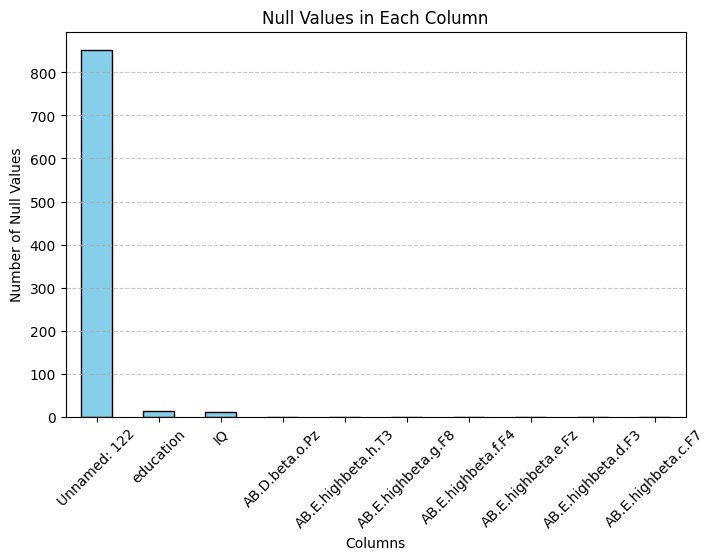

In [480]:
# Plot null values before removal

import numpy as np
import matplotlib.pyplot as plt

null_counts = df.isnull().sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(8, 5))

null_counts.plot(kind='bar', color='skyblue', edgecolor='black')

plt.xlabel('Columns')
plt.ylabel('Number of Null Values')
plt.title('Null Values in Each Column')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

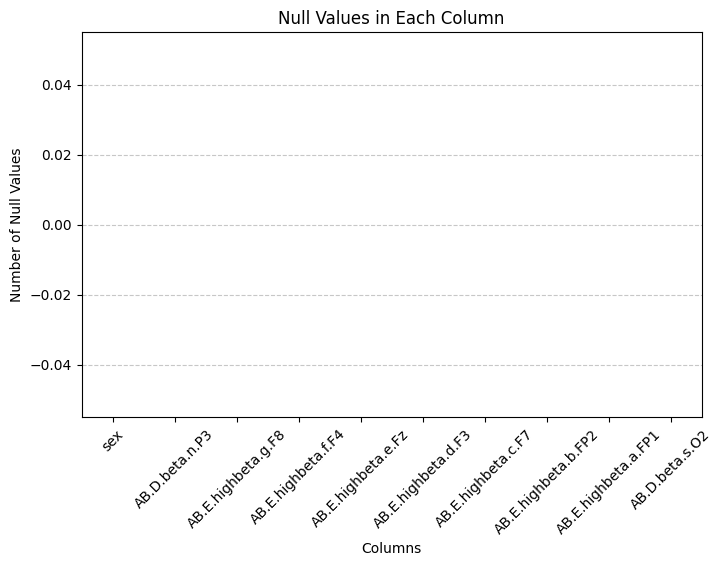

In [481]:
df_dropped = df.drop(columns=['Unnamed: 122']).dropna()

null_counts = df_dropped.isnull().sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(8, 5))
null_counts.plot(kind='bar')

plt.xlabel('Columns')
plt.ylabel('Number of Null Values')
plt.title('Null Values in Each Column')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

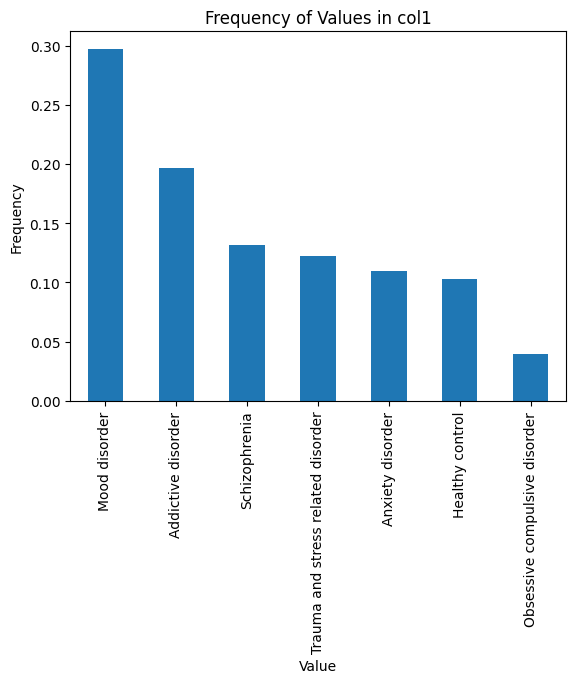

In [482]:
value_counts = df_dropped['main.disorder'].value_counts() / len(df_dropped)

value_counts.plot(kind='bar')
plt.title('Frequency of Values in col1')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.show()

In [483]:
# Calculate correlation matrix, drop columns with > .95 correlation,
# demonstrable improvement in model performance.

df_numbers = df_dropped.select_dtypes(include=[np.number])
corr_matrix = df_numbers.corr().abs()
upper_matrix = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

to_drop = [column for column in upper_matrix.columns if any(upper_matrix[column] > 0.95)]

print(to_drop)

df_deduplicate = df_dropped.drop(to_drop, axis=1)
test_df.drop(to_drop, axis=1, inplace=True)

print(len(to_drop))

['AB.B.theta.b.FP2', 'AB.B.theta.e.Fz', 'AB.B.theta.f.F4', 'AB.B.theta.k.C4', 'AB.C.alpha.b.FP2', 'AB.C.alpha.c.F7', 'AB.C.alpha.d.F3', 'AB.C.alpha.e.Fz', 'AB.C.alpha.f.F4', 'AB.C.alpha.g.F8', 'AB.C.alpha.i.C3', 'AB.C.alpha.j.Cz', 'AB.C.alpha.k.C4', 'AB.C.alpha.p.P4', 'AB.D.beta.b.FP2', 'AB.D.beta.e.Fz', 'AB.D.beta.f.F4', 'AB.E.highbeta.f.F4', 'AB.E.highbeta.p.P4', 'AB.F.gamma.f.F4', 'AB.F.gamma.o.Pz', 'AB.F.gamma.p.P4', 'AB.F.gamma.r.O1', 'AB.F.gamma.s.O2']
24


In [484]:
# An attempt at feature engineering, was not successful

"""
waves = ['alpha', 'beta', 'theta', 'delta']

for wave in waves:
  df_deduplicate[wave] = df_deduplicate[[x for x in df_deduplicate.columns if wave in x]].apply(sum, axis=1)
  test_df[wave] = test_df[[x for x in test_df.columns if wave in x]].apply(sum, axis=1)

df_deduplicate.to_csv('/content/pen.csv')


electrodes = list(set([x.split('.')[-1] for x in df_deduplicate.columns if x.startswith('AB')]))

for wave in electrodes:
  df_deduplicate[wave] = df_deduplicate[[x for x in df_deduplicate.columns if x.endswith(wave)]].apply(sum, axis=1)

df_deduplicate.to_csv('/content/pen.csv')
"""


"\nwaves = ['alpha', 'beta', 'theta', 'delta']\n\nfor wave in waves:\n  df_deduplicate[wave] = df_deduplicate[[x for x in df_deduplicate.columns if wave in x]].apply(sum, axis=1)\n  test_df[wave] = test_df[[x for x in test_df.columns if wave in x]].apply(sum, axis=1)\n\ndf_deduplicate.to_csv('/content/pen.csv')\n\n\nelectrodes = list(set([x.split('.')[-1] for x in df_deduplicate.columns if x.startswith('AB')]))\n\nfor wave in electrodes:\n  df_deduplicate[wave] = df_deduplicate[[x for x in df_deduplicate.columns if x.endswith(wave)]].apply(sum, axis=1)\n\ndf_deduplicate.to_csv('/content/pen.csv')\n"

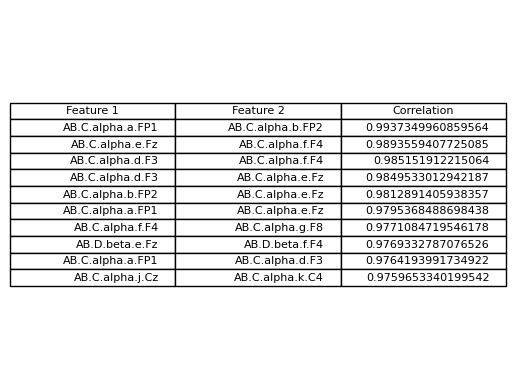

In [485]:
corr_unstacked = upper_matrix.stack().reset_index()
corr_unstacked.columns = ['Feature 1', 'Feature 2', 'Correlation']
corr_unstacked = corr_unstacked.sort_values(by='Correlation', ascending=False)
corr_unstacked_filtered = corr_unstacked[corr_unstacked['Correlation'] != 0]
corr_table = corr_unstacked_filtered.head(10)

fig, ax = plt.subplots()
ax.axis('off')
table = ax.table(cellText=corr_table.values, colLabels=corr_table.columns, loc='center')
plt.show()

In [486]:
from sklearn.preprocessing import LabelEncoder

df_deduplicate['sex'] = LabelEncoder().fit_transform(df_deduplicate['sex'])

test_df['sex'] = LabelEncoder().fit_transform(test_df['sex'])

In [487]:
from sklearn.model_selection import train_test_split

def generate_train_test(X, y, test_size=0.2, random_state=10):
  if real_testing:
    return X, test_df, y, pd.DataFrame('Healthy control', index=range(len(test_df)), columns=['main.disorder'])
  return train_test_split(X, y, test_size=test_size)

In [488]:
# Support Vector Machines

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

X = df_deduplicate.drop(columns=['main.disorder'])
y = df_deduplicate['main.disorder']


X_train, X_test, y_train, y_test = generate_train_test(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# TODO: Show change after class weight
svm_model = SVC(kernel='rbf', class_weight='balanced')
svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)

if real_testing:
  y_frame = pd.DataFrame(y_pred, columns=['main.disorder.class'])
  test_df_ids.join(y_frame).to_csv('svm_results.csv', index=False)
else:
  print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
  print("Classification Report:")
  print(classification_report(y_test, y_pred))

  disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, xticks_rotation='vertical')
  disp.ax_.set_title("SVM Confusion Matrix")
  plt.show()

In [489]:
from sklearn.linear_model import LogisticRegression

if not real_testing:
  for disorder in ['Addictive disorder', 'Anxiety disorder', 'Mood disorder', 'Obsessive compulsive disorder', 'Schizophrenia', 'Trauma and stress related disorder']:
    label_encoder = LabelEncoder()
    X_train, X_test, y_train, y_test = generate_train_test(X, y, test_size=0.2, random_state=10)
    X_train = X_train[y_train.isin([disorder, 'Healthy control'])]
    y_train = y_train[y_train.isin([disorder, 'Healthy control'])]
    X_test = X_test[y_test.isin([disorder, 'Healthy control'])]
    y_test = y_test[y_test.isin([disorder, 'Healthy control'])]

    y_train = label_encoder.fit_transform(y_train)
    y_test = label_encoder.fit_transform(y_test)
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)



    """
    xgb_model = xgb.XGBClassifier(n_estimators=150)

    xgb_model.fit(X_train, y_train)

    y_pred = xgb_model.predict(X_test)
    """

    model = LogisticRegression(
        penalty='elasticnet',
        solver='saga',
        l1_ratio=0.5,
        C=1.0,
        max_iter=2500,
        tol=1e-4,
        random_state=42,
        n_jobs=-1
    )

    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    print(f"Accuracy: {accuracy_score(label_encoder.inverse_transform(y_test), label_encoder.inverse_transform(y_pred))}")
    print("Classification Report:")
    print(classification_report(label_encoder.inverse_transform(y_test), label_encoder.inverse_transform(y_pred)))

In [490]:
import xgboost as xgb

label_encoder = LabelEncoder()

xgb_model = xgb.XGBClassifier(eval_metric='mlogloss')

X_train, X_test, y_train, y_test = generate_train_test(X, y, test_size=0.2, random_state=42)
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

if real_testing:
  y_frame = pd.DataFrame(label_encoder.inverse_transform(y_pred), columns=['main.disorder.class'])
  test_df_ids.join(y_frame).to_csv('xgb_results.csv', index=False)
else:
  print(f"Accuracy: {accuracy_score(label_encoder.inverse_transform(y_test), label_encoder.inverse_transform(y_pred))}")
  print(f"Classification report: {classification_report(label_encoder.inverse_transform(y_test), label_encoder.inverse_transform(y_pred))}")
  disp = ConfusionMatrixDisplay.from_predictions(label_encoder.inverse_transform(y_test), label_encoder.inverse_transform(y_pred), xticks_rotation='vertical')
  disp.ax_.set_title("XGBoost Confusion Matrix")
  plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


Text(0.5, 0, 'XGBoost Feature Importance')

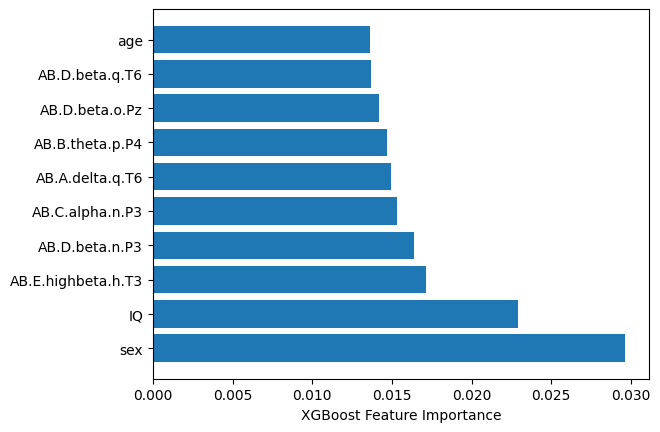

In [491]:
sorted_idx = xgb_model.feature_importances_.argsort()[::-1][:10]
plt.barh(X.columns[sorted_idx], xgb_model.feature_importances_[sorted_idx])
plt.xlabel("XGBoost Feature Importance")

In [492]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(class_weight='balanced', n_estimators=20)

rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

if real_testing:
  y_frame = pd.DataFrame(label_encoder.inverse_transform(y_pred), columns=['main.disorder.class'])
  test_df_ids.join(y_frame).to_csv('rf_results.csv', index=False)
else:
  print(f"Accuracy: {accuracy_score(label_encoder.inverse_transform(y_test), label_encoder.inverse_transform(y_pred))}")
  print(f"Classification report: {classification_report(label_encoder.inverse_transform(y_test), label_encoder.inverse_transform(y_pred))}")
  disp = ConfusionMatrixDisplay.from_predictions(label_encoder.inverse_transform(y_test), label_encoder.inverse_transform(y_pred), xticks_rotation='vertical')
  disp.ax_.set_title("Random Forest Confusion Matrix")
  plt.show()